In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets axial_positional_embedding
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git

     |████████████████████████████████| 194kB 19.1MB/s 
     |████████████████████████████████| 163kB 14.5MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 17.7MB 212kB/s 
     |████████████████████████████████| 245kB 50.3MB/s 


In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#all_slow

# enwik8 - Reversible

In [ ]:
from fastai.text.all import *

from reformer_fastai.tokenizers import ByteTextTokenizer
from reformer_fastai.reformer import ReversibleLM
from reformer_fastai.data import read_and_prepare_data, read_lines
from reformer_fastai.metrics import BPC
from reformer_fastai.optimizers import adafactor

## Experiment Tracking

Make sure you have wandb and are logged in:

In [ ]:
# hide
!pip install -Uqq wandb
!wandb login

     |████████████████████████████████| 1.8MB 19.7MB/s 
     |████████████████████████████████| 133kB 61.5MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
     |████████████████████████████████| 163kB 46.2MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'enc_lm_enwik8_reversible_af'
GROUP = 'TEST'
NOTES = 'ReversibleLM on enwik8 sl 1024 using irrev blocks'
CONFIG = {}
TAGS = ['lm','rev','enwik8']

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [ ]:
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, config=CONFIG, tags=TAGS)

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [ ]:
#hide_output
!wget http://mattmahoney.net/dc/enwik8.zip
!unzip enwik8.zip -d storage/
!ls storage
!head -n 10 data/enwik8

--2021-01-03 19:52:57--  http://mattmahoney.net/dc/enwik8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36445475 (35M) [application/zip]
Saving to: ‘enwik8.zip’

enwik8.zip          100%[===================>]  34.76M  3.64MB/s    in 9.6s    

2021-01-03 19:53:07 (3.62 MB/s) - ‘enwik8.zip’ saved [36445475/36445475]

Archive:  enwik8.zip
  inflating: storage/enwik8          
enwik8
head: cannot open 'data/enwik8' for reading: No such file or directory


## Prepare Data

In [ ]:
df = pd.DataFrame({'text':read_lines('storage/enwik8')})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [ ]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [ ]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 2min 8s, sys: 3.26 s, total: 2min 11s
Wall time: 2min 7s


In [ ]:
train_cutoff = df.lens.sum() - 10_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [ ]:
#hide
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]

In [ ]:
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
%%time
bs, sl = 8, 1024
# pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 29.2 s, sys: 1.79 s, total: 31 s
Wall time: 36.5 s


In [ ]:
#collapse_output
dls.show_batch(max_n=2)

,text,text_
0,"**[http://www.gutenberg.net/etext/12073 Letters of Horace Walpole, Volume I]\n*[[Beta rays]] \nIn the modern comics' canon, years before Clark or Lois began working for the paper, [[Lex Luthor]] owned the ''Daily Planet.'' When Luthor, deciding to sell the paper, began taking bids for the ''Planet'', Perry White convinced an international conglomerate, TransNational Enterprises, to buy the paper. They agreed to this venture with only one stipulation: that Perry White would become editor-in-chief. White has served as the ''Planet'' editor-in-chief ever since, barring the few times he was absent. During those times people such as [[Sam Foswell]] and Clark Kent have looked after the paper. [[Franklin Stern]], an old friend of White's, became the ''Daily Planet'''s publisher.\n\n*Corey Robin (2004), ''Fear: the history of a political idea'', Oxford University Press\n[[es:Bernardo de Claraval]]\n| regnum = [[Animal]]ia\n{{main|Carbohydrate}}\n[[sv:David Hume]]\n[[hr:Domicijan]]\n== Pop and Rock == \n[[Category:Alice charact","*[http://www.gutenberg.net/etext/12073 Letters of Horace Walpole, Volume I]\n*[[Beta rays]] \nIn the modern comics' canon, years before Clark or Lois began working for the paper, [[Lex Luthor]] owned the ''Daily Planet.'' When Luthor, deciding to sell the paper, began taking bids for the ''Planet'', Perry White convinced an international conglomerate, TransNational Enterprises, to buy the paper. They agreed to this venture with only one stipulation: that Perry White would become editor-in-chief. White has served as the ''Planet'' editor-in-chief ever since, barring the few times he was absent. During those times people such as [[Sam Foswell]] and Clark Kent have looked after the paper. [[Franklin Stern]], an old friend of White's, became the ''Daily Planet'''s publisher.\n\n*Corey Robin (2004), ''Fear: the history of a political idea'', Oxford University Press\n[[es:Bernardo de Claraval]]\n| regnum = [[Animal]]ia\n{{main|Carbohydrate}}\n[[sv:David Hume]]\n[[hr:Domicijan]]\n== Pop and Rock == \n[[Category:Alice characte"
1,"]]. The name &amp;#8220;H.G. Wells&amp;#8221; appeared high on the list for the &quot;crime&quot; of being a socialist. Wells, as president of the International [[PEN]] (Poets, Essayists, Novelists), had already angered the [[Nazism|Nazis]] by overseeing the expulsion of the German PEN club from the international body in 1934 following the German PEN's refusal to admit non-[[Aryan]] writers to its membership.\n <id>11064</id>\n[[es:Hipertiroidismo]]\n[[Category:Open source licenses]]\n\n[[de:Buch Nehemia]]\n\n\n\n <text xml:space=""preserve"">{{expert}}\nIn the [[politics of the European Union]], any decision taken using the [[codecision procedure]] requires an absolute majority in [[European Parliament]] in order to amend a text in its second reading. (At first reading, only a [[simple majority]] is required.)\n </contributor>\n* [[Eurovision Song Contest 1985]]\n** [[CMX (comics)|CMX]]\n </page>\nEdinburgh Multi Access System&lt;br&gt;\n*[[1886]] - [[Hugo Ball]], German author and poet (d. [[1927]])\n==Examples=","]. The name &amp;#8220;H.G. Wells&amp;#8221; appeared high on the list for the &quot;crime&quot; of being a socialist. Wells, as president of the International [[PEN]] (Poets, Essayists, Novelists), had already angered the [[Nazism|Nazis]] by overseeing the expulsion of the German PEN club from the international body in 1934 following the German PEN's refusal to admit non-[[Aryan]] writers to its membership.\n <id>11064</id>\n[[es:Hipertiroidismo]]\n[[Category:Open source licenses]]\n\n[[de:Buch Nehemia]]\n\n\n\n <text xml:space=""preserve"">{{expert}}\nIn the [[politics of the European Union]], any decision taken using the [[codecision procedure]] requires an absolute majority in [[European Parliament]] in order to amend a text in its second reading. (At first reading, only a [[simple majority]] is required.)\n </contributor>\n* [[Eurovision Song Contest 1985]]\n*

In [ ]:
vocab_sz = btt.vocab_size

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 1024]), torch.Size([8, 1024]))

In [ ]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

In [ ]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [ ]:
#opt_func = partial(adafactor, warmup_init=True)
opt_func = adafactor

learn = Learner(dls, ReversibleLM(vocab_sz, 1024, n_layers=3, max_seq_len=sl, rev_thres=1025), #using irrev blocks for speed
                loss_func=CrossEntropyLossFlat(), opt_func=opt_func,
                metrics=[accuracy, perplexity, BPC()],
                cbs=TerminateOnNaNCallback()).to_native_fp16()

In [ ]:
#hide
learn.lr_find()

In [ ]:
learn.fit(3, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,1.444021,1.389910,0.592767,4.014487,0.963412,1:10:46


Buffered data was truncated after reaching the output size limit.

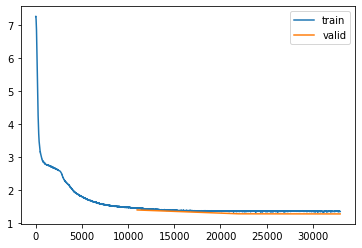

In [ ]:
learn.recorder.plot_loss()